## Testing inference

In [61]:
from datasets import data_merge_R
from transformers import *
import cv2
import matplotlib.pyplot as plt
import os
import torch
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from networks import get_model
from networks import SSAN_R
from utils import *
from utils.performance import performance_double_val
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# check main_test_set and new_masks set
main_test_set = pd.read_csv('data/test_list_m1_m3_m4_main_test.csv')
new_mask_same_live = pd.read_csv('data/test_list_mask_2types_live(test).csv')

print('main_test_set: ')
print('columns: ', main_test_set.columns)
print('size: ', main_test_set.shape)

print('\nnew_mask_same_live: ')
print('columns: ', new_mask_same_live.columns)
print('size: ', new_mask_same_live.shape)

main_test_set: 
columns:  Index(['0', '1'], dtype='object')
size:  (16844, 2)

new_mask_same_live: 
columns:  Index(['fname', 'label'], dtype='object')
size:  (26770, 2)


In [22]:
print('Amount of live data in main_test_set: ',new_mask_same_live[new_mask_same_live.label==1].shape[0])
print('Amount of live data in new_test_set: ',main_test_set[main_test_set['1']==1].shape[0])

Amount of live data in main_test_set:  12079
Amount of live data in new_test_set:  12108


In [37]:
new_live = new_mask_same_live[new_mask_same_live.label==1].reset_index(drop=True)
main_live = main_test_set[main_test_set['1']==1].reset_index(drop=True)


new_live_list = [img_name.split('/')[-1] for img_name in new_live.fname]
main_live_list = [img_name.split('/')[-1] for img_name in main_live['0']]

print('amount of new_live images: ', len(new_live_list))
print('amount of main_live images: ', len(main_live_list))

amount of new_live images:  12079
amount of main_live images:  12108


Image path:  /media/user/685b3289-4051-4530-9827-ef770d2e3f28/ml_projects_yeldar/patchnet/M1_3_4_test/live/912b7752-c93c-494f-be98-9dea2c6966d7.jpeg


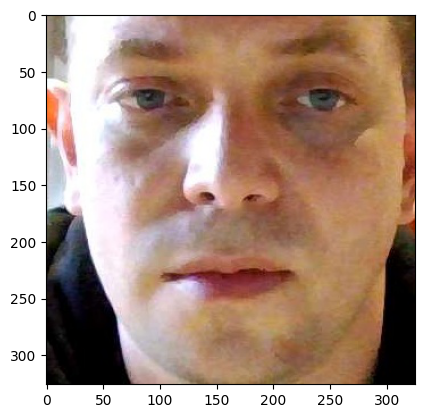

In [62]:
print("Image path: ", new_live.fname[10960])
img = cv2.imread(new_live.fname[10960])

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [71]:
main_test_set['is_img_path_exists'] = pd.Series([os.path.exists(path) for path in main_test_set['0']])
main_test_set.is_img_path_exists.value_counts()

is_img_path_exists
False    16844
Name: count, dtype: int64

In [67]:
print(main_live['0'][0])

print(os.path.exists(main_live['0'][0]))

/mnt/8TB/ml_projects_yeldar/patchnet/M1_3_4_test/live/912b7752-c93c-494f-be98-9dea2c6966d7.jpeg
False


In [63]:
print("Image path: ", main_live['0'][0])
img = cv2.imread(main_live['0'][0])

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Image path:  /mnt/8TB/ml_projects_yeldar/patchnet/M1_3_4_test/live/912b7752-c93c-494f-be98-9dea2c6966d7.jpeg


[ WARN:0@4453.710] global /home/conda/feedstock_root/build_artifacts/libopencv_1658995930611/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/mnt/8TB/ml_projects_yeldar/patchnet/M1_3_4_test/live/912b7752-c93c-494f-be98-9dea2c6966d7.jpeg'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /home/conda/feedstock_root/build_artifacts/libopencv_1658995930611/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [57]:
print(new_live_list.index('912b7752-c93c-494f-be98-9dea2c6966d7.jpeg'))
main_live_list[:5]

10960


['912b7752-c93c-494f-be98-9dea2c6966d7.jpeg',
 'vid_2983_frameNr_137_Infinix S4_0001e96803--622d8f9b5a22ca134095c715_2e4d03d0cfe7758cff06b63f4c575ccd_27_KE_MALE.png',
 '9bb8de92-1152-40e8-9eef-a113e81ad10d.jpg',
 'live_003396_000001.jpg',
 'f17615f6-bbc0-4caa-a937-6e1a25def028.jpg']

In [43]:
# print('amount of new_live list images: ', len(new_live_list))
# print('amount of main_live list images: ', len(main_live_list))
print('difference of duplicated images ', len(main_live_list) - len(new_live_list))

# print('amount of new_live set images: ', len(set(new_live_list)))
# print('amount of main_live set images: ', len(set(main_live_list)))

difference_of_unique_images = set(new_live_list).difference(set(main_live_list))
print('difference of unique images ', len(difference_of_unique_images))

difference of duplicated images  29
difference of unique images  0


In [ ]:
print('amount of new_live list images: ', len(new_live_list))
print('amount of main_live list images: ', len(main_live))

In [4]:
def inference(PATH, img_size=112, type='test', train_datasets='M1', batch_size=256):
    num_workers = 8

    data_bank = data_merge_R.data_merge()
    model = SSAN_R().cuda()
    state = torch.load(PATH)
    model.load_state_dict(state['state_dict'])

 # Original input data loader
    test_data_dic = data_bank.get_datasets(type=type, img_size=img_size, transform=transformer_test_video())
    test_loader = DataLoader(test_data_dic, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # # BGR formatted data loader
    # bgr_test_data_dic = data_bank.get_datasets(type=type, img_size=img_size, transform=transformer_test_video(bgr=True))
    # bgr_test_loader = DataLoader(bgr_test_data_dic, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # model.eval()
    # with torch.no_grad():
    #     original_scores = []
    #     bgr_scores = []
    #     labels = []

    #     # Inference for original input
    #     for i, sample_batched in enumerate(tqdm(test_loader)):
    #         image_x, label = sample_batched["image_x"].cuda(), sample_batched["label"].cuda()
    #         cls_x1_x1, fea_x1_x1, fea_x1_x2, _ = model(image_x, image_x)
    #         score_norm = torch.softmax(cls_x1_x1, dim=1)[:, 1]

    #         for ii in range(image_x.shape[0]):
    #             original_scores.append(score_norm[ii].detach().cpu().numpy())
    #             labels.append(label[ii][0].detach().cpu().numpy())

    #     # Inference for BGR formatted input
    #     for i, sample_batched in enumerate(tqdm(bgr_test_loader)):
    #         image_x, label = sample_batched["image_x"].cuda(), sample_batched["label"].cuda()
    #         cls_x1_x1, fea_x1_x1, fea_x1_x2, _ = model(image_x, image_x)
    #         score_norm = torch.softmax(cls_x1_x1, dim=1)[:, 1]

    #         for ii in range(image_x.shape[0]):
    #             bgr_scores.append(score_norm[ii].detach().cpu().numpy())
                        
    #     map_score_val_filename = os.path.join('./', f"test_score_{img_size}_{train_datasets}.txt")
    #     print(f"score: write test scores to {map_score_val_filename}")

    #     with open(map_score_val_filename, 'w') as file:
    #         count = 0
    #         for orig_score, bgr_score in zip(original_scores, bgr_scores):
    #             # Writing original score, BGR score, and label in each line
    #             final_score = min(orig_score, bgr_score)
    #             file.write(f"{final_score:.6f} {labels[count]}\n")
    #             count += 1

    #     _, _, _, HTER, auc_test, _ = performance_double_val(original_scores, bgr_scores, labels)
    #     best_epoch = state['epoch']
    #     print(best_epoch)
    #     return best_epoch, HTER, auc_test,


    model.eval()
    with torch.no_grad():
        scores = []
        for i, sample_batched in enumerate(tqdm(test_loader)):
            image_x, label = sample_batched["image_x"].cuda(), sample_batched["label"].cuda()

            cls_x1_x1, fea_x1_x1, fea_x1_x2, _ = model(image_x, image_x)
            score_norm = torch.softmax(cls_x1_x1, dim=1)[:, 1]

            for ii in range(image_x.shape[0]):
                scores.append("{} {}\n".format(score_norm[ii], label[ii][0]))
                        
        map_score_val_filename = os.path.join('./', f"test_score_{img_size}_{train_datasets}.txt")
        print("score: write test scores to {}".format(map_score_val_filename))
        with open(map_score_val_filename, 'w') as file:
            file.writelines(scores)

        _, _, _, HTER, auc_test, _ = performances_val(map_score_val_filename)
        best_epoch = state['epoch']
        print(best_epoch)
        return best_epoch, HTER, auc_test



In [67]:
train_datasets = 'M134'
img_size=112
# PATH = f'./results/SSAN_R_{img_size}_{train_datasets}/model/SSAN_R_pPatchnet_best.pth'
PATH = f'./results/Experiment/model/SSAN_R_best.pth'
# PATH = f'/home/user/ml_projects/Yeldar/results/ssan/Experiment 24/model/SSAN_R_best.pth'
# PATH="smth"
# PATH = f'/home/user/ml_projects/Yeldar/SSAN/results/Experiment/model/SSAN_R_best.pth'
# PATH = f'/home/user/ml_projects/Yeldar/SSAN/results/SSAN_R_pPatchnet_best_v1.pth'
best_epoch, HTER, auc_test = inference(PATH, img_size=img_size, type='test', train_datasets=train_datasets, batch_size=256)
sc_p = os.path.join("/".join(PATH.split('/')[:-2]), "score")
total_epoch = max([int(x.split('_')[-1]) for x in os.listdir(sc_p)])
print("epoch:{:d}/{:d}, HTER={:.4f}, AUC={:.4f}".format(best_epoch, total_epoch, HTER, auc_test))

/home/user/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading dataset, number: 26770
Total number: 26770


100%|██████████| 105/105 [00:07<00:00, 13.71it/s]

score: write test scores to ./test_score_112_M134.txt
31
epoch:31/2299, HTER=0.0683, AUC=0.9810


# Model's metrics

In [68]:
from sklearn.metrics import confusion_matrix
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score


def find_best_threshold_with_gini(y_true, y_pred_probs):
    """
    Find the best threshold for a binary classifier using the Gini index.

    Parameters:
        y_true (array-like): The true binary labels (0 or 1).
        y_pred_probs (array-like): The predicted probabilities from the classifier.

    Returns:
        best_threshold (float): The threshold that maximizes the Gini index.
        best_gini (float): The maximum Gini index achieved.
    """
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    
    # Calculate the AUC-ROC
    auc = roc_auc_score(y_true, y_pred_probs)
    
    # Initialize variables to keep track of the best threshold and Gini index
    best_gini = 0
    best_threshold = None
    
    # Iterate through each threshold in the ROC curve
    for i, threshold in enumerate(thresholds):
        # Calculate the Gini index for the current threshold
        current_gini = tpr[i] - fpr[i]
        
        # Update the best threshold and Gini index if the current one is better
        if current_gini > best_gini:
            best_gini = current_gini
            best_threshold = threshold
    
    return best_threshold, best_gini


def overall_result(y_, y_predicted):
# save confusion matrix and slice into four pieces

    conf_matrix = confusion_matrix(y_, y_predicted)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]


    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))

    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy

    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    conf_far = FN/float(TP + FN)
    conf_frr = FP/float(TN + FP)

    result_s = {}
    result_s['Accuracy']           = [str(round(conf_accuracy,4)*100)+'%']
#    result_s['Mis-Classification'] = [str(round(conf_misclassification,2)*100)+' %']
#     result_s['Sensitivity']        = [round(conf_sensitivity,2)]
#     result_s['Specificity']        = [round(conf_specificity,2)]
    result_s['Recall']        = [str(round(conf_sensitivity,4)*100)+'%']
    result_s['Precision']          = [str(round(conf_precision,4)*100)+'%']
    result_s['F1 Score']           = [str(round(conf_f1,4)*100)+'%']
    result_s['FRR']                = [str(round(conf_far,4)*100)+'%']
    result_s['FAR']                = [str(round(conf_frr,4)*100)+'%']
    #result_s['inference_time']     = [str(round(sum(inferences_time),2))+ 's']
    #result_s['MCC']                = [round(matthews_corrcoef(y_, y_predicted),2)]
    

    df_result           = pd.DataFrame(result_s)
    
    return df_result

In [69]:
def read_calc_plot(map_score_val_filename):
    with open(map_score_val_filename, 'r') as file:
        lines = file.readlines()
    val_scores = []
    val_labels = []
    count = 0.0
    for line in lines:
        # try:
        count += 1
        tokens = line.split()
        score = float(tokens[0])
        label = float(tokens[1])  # int(tokens[1])
        val_scores.append(score)
        val_labels.append(label)
    y_true = np.array(val_labels)
    y_true = y_true.astype(int)
    y_pred = np.array(val_scores)

    # # Find the best threshold and Gini index
    best_threshold, best_gini = find_best_threshold_with_gini(y_true, y_pred)

    print(f"Best threshold: {best_threshold}")
    print(f"Best Gini index: {best_gini}")

    # thrs = range(best_thr)
    # for thr in thrs:

    # best_threshold = 0.995
    # print(f"Threshold: {best_threshold}")

    y_pred = [1 if score>best_threshold else 0 for score in y_pred] 
    # 1 = live  
    #0=mask

    metrics = overall_result(y_true, y_pred)
    print(metrics)
    colors_lightsteelblue = ['#CAE1FF', '#BCD2EE', '#A2B5CD', '#6E7B8B']

    fig,ax=plt.subplots(1,1,figsize=(5,5))
    sns.heatmap(confusion_matrix(y_true,y_pred),ax=ax,xticklabels=['pred_mask', 'pred_live'],
                yticklabels=['mask', 'live'],
                annot=True,fmt='g',annot_kws={"size": 14},
            cmap=colors_lightsteelblue[::1],alpha=0.7,linewidths=5,linecolor=colors_lightsteelblue[2])
    fig.text(s='Mask Detection th=...',size=13,fontweight='bold',
                fontname='monospace',color='black',y=0.92,x=0.28,alpha=0.8)
    sns.set(font_scale=1.1)
    plt.show()
    return best_threshold

Best threshold: 0.9960611462593079
Best Gini index: 0.8697667578127023
  Accuracy  Recall Precision            F1 Score                 FRR    FAR
0   93.25%  95.89%    89.84%  92.75999999999999%  4.109999999999999%  8.92%


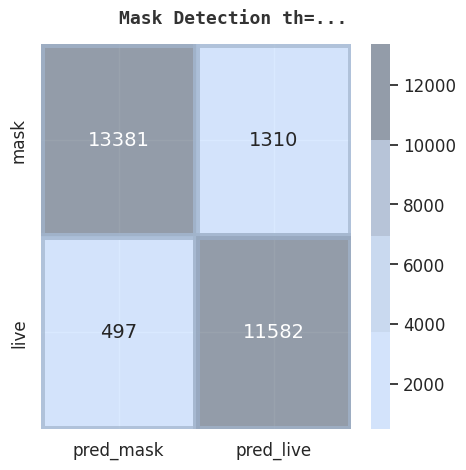

In [72]:
map_score_val_filename = 'test_score_112_M134.txt'
best_threshold = read_calc_plot(map_score_val_filename)

## Saving not correctly labeled images

In [36]:
map_score_val_filename = 'test_score_112_M134.txt'

with open(map_score_val_filename, 'r') as file:
    lines = file.readlines()
val_scores = []
val_labels = []
data = []
count = 0.0
for line in lines:
    # try:
    count += 1
    tokens = line.split()
    score = float(tokens[0])
    label = int(tokens[1])  # int(tokens[1])
    val_scores.append(score)
    val_labels.append(label)

In [37]:
thr = 0.9960611462593079
cnt = 0
inds = []
for i in range(len(val_labels)):
    pred_label = 0 if val_scores[i] < thr else 1
    if val_labels[i]!=pred_label & pred_label == 0:
        # print(i, val_scores[i], val_labels[i], pred_label)
        inds.append(i)
        cnt += 1
print(cnt)

496


In [38]:
df = pd.read_csv('./data/test_list_mask.csv')
df.columns = ['fname', 'label']
df

,fname,label
0,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,0
1,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,0
2,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,0
3,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,0
4,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,0
...,...,...
26765,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1
26766,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1
26767,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1
26768,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1


In [42]:
df['fname'].iloc[0]

'/media/user/685b3289-4051-4530-9827-ef770d2e3f28/ml_projects_yeldar/cropped_youtube_insta_tiktok/Here she comes call Kali/frameNr_420_Here she comes call Kali.jpg'

In [40]:
df.loc[inds]
# df[df['label']==1]

,fname,label
14704,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1
14728,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1
14736,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1
14744,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1
14764,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1
...,...,...
26692,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1
26712,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1
26736,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1
26751,/media/user/685b3289-4051-4530-9827-ef770d2e3f...,1


In [41]:
import shutil

# Iterate over each row in the DataFrame
save_fold = "/home/user/ml_projects/Yeldar/results/ssan/wrong_identified_labels"
for _, row in df.loc[inds].iterrows():
    file_path = row['fname']
    # file_path = file_path.replace('/mnt/8TB', '/media/user/685b3289-4051-4530-9827-ef770d2e3f28')
    # Check if the file exists to avoid errors
    if os.path.isfile(file_path):
        shutil.copy(file_path, save_fold)


## Analyzing density plots

In [28]:
import os
import pandas as pd
df = pd.read_csv('data/full_mask_detection_dataset.csv')
# df = df.rename(columns={'image_name': 'fname'})
# df = pd.read_csv('data/completed_test.csv')
df['img_basename'] = df['image_name'].apply(lambda x: os.path.basename(x))
# df[df['label']==1].groupby(['dataset']).count()
df

,image_name,subject,dataset,label,img_basename
0,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_1,IDRND,1,real_1_01.png
1,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_10,IDRND,1,real_10_01.png
2,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_100,IDRND,1,real_100_01.png
3,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_1000,IDRND,1,real_1000_01.png
4,/mnt/22TB/Nurmukhammed/CROPPED_FAS_DATASETS/RE...,real_1001,IDRND,1,real_1001_01.png
...,...,...,...,...,...
72335,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_75_IMG_6583.jpg
72336,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_80_IMG_6583.jpg
72337,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_90_IMG_6583.jpg
72338,/mnt/22TB/Nurmukhammed/SILICON_MASKS_DATASETS/...,IMG_6583,silicon_mask_biometric,0,frameNr_95_IMG_6583.jpg


In [ ]:
map_score_val_filename = 'test_score_112_M134.txt'

with open(map_score_val_filename, 'r') as file:
    lines = file.readlines()
val_scores = []
val_labels = []
data = []
count = 0.0
for line in lines:
    # try:
    count += 1
    tokens = line.split()
    score = float(tokens[0])
    label = int(tokens[1])  # int(tokens[1])
    val_scores.append(score)

dpath = './data/test_list11.csv'
# dpath = '/mnt/8TB/ml_projects_yeldar/patchnet/train/train_list.csv'
# test_data2 = pd.read_csv(dpath)
test_data = pd.read_csv(dpath)
test_data.columns = ['fname', 'label']
test_data['img_basename'] = test_data['fname'].apply(lambda x: os.path.basename(x))
test_data['score'] = val_scores
test_data

In [ ]:
dpath = './data/test_list11.csv'
# dpath = '/mnt/8TB/ml_projects_yeldar/patchnet/train/train_list.csv'
test_data = pd.read_csv(dpath)
# test_data = pd.read_csv(dpath)
test_data.columns = ['fname', 'label']
test_data[test_data['label']==0]

In [ ]:
test_data = pd.merge(test_data, df, on=['img_basename'], how='left')
# test_data = pd.merge(test_data, test_data2, on=['fname'], how='outer')
test_data = test_data.drop(columns=['label_y', 'image_name'])
test_data = test_data.rename(columns={"label_x":"label"})
test_data
# non_intersecting_rows = test_data[~test_data['fname'].isin(test_data2['fname'])]
# non_intersecting_rows

In [ ]:
test_data[test_data['label']==1].groupby(['dataset'])['score'].describe()
# test_data[test_data['label']==1].groupby(['dataset']).count()

In [ ]:
a = test_data[test_data['dataset'] == 'youtube_google']
a[a['label']==1].iloc[0]['fname']

In [ ]:
test_data[test_data['label']==0].groupby(['dataset'])['score'].describe()


In [ ]:
# test_data[test_data['label']==0].groupby(['dataset'])['score'].describe()
test_data[test_data['label']==0].groupby(['dataset']).count()

In [ ]:
plt.figure(figsize=(10, 4))
sns.kdeplot(data=test_data[test_data['label']==1], x="score", hue="dataset", fill=True, common_norm=False, alpha=0.4, legend=True)
plt.title('SSAN_R results on patchnet test data')
plt.show()

In [ ]:
plt.figure(figsize=(10, 4))
sns.kdeplot(data=test_data[test_data['label']==0], x="score", hue="dataset", fill=True, common_norm=False, alpha=0.4, legend=True)
# sns.displot(data=test_data[test_data['label']==1], x="score")
plt.show()

In [ ]:
for dataset in  test_data[test_data['label']==1]['dataset'].unique():
    y_true = np.ones(len( test_data[test_data['label']==1][test_data['dataset']==dataset]['score']))
    y_pred =  test_data[test_data['label']==1][test_data['dataset']==dataset]['score']
    y_pred = [1 if score>best_threshold else 0 for score in y_pred]
    print(dataset,round(sum(y_pred)/len(test_data[test_data['label']==1][test_data['dataset']==dataset]['score']), 3)*100,'%')
    # print(dataset,sum(y_pred), len( test_data[test_data['label']==1][test_data['dataset']==dataset]['score']))


In [ ]:
print('results_with_random_crop_mask \n')

for dataset in  test_data[test_data['label']==0]['dataset'].unique():
    y_true = np.ones(len( test_data[test_data['label']==0][test_data['dataset']==dataset]['score']))
    y_pred =  test_data[test_data['label']==0][test_data['dataset']==dataset]['score']
    y_pred = [1 if score<best_threshold  else 0 for score in y_pred]
    # print(dataset,sum(y_pred), len( test_data[test_data['label']==0][test_data['dataset']==dataset]['score']))
    print(dataset,round(sum(y_pred)/len(test_data[test_data['label']==0][test_data['dataset']==dataset]['score']), 3)*100,'%')
    # print(dataset,round(sum(y_pred)))

In [ ]:
best_threshold

## Parsing mfkin csvs

In [ ]:
tp = 'train'
train_csv = f'datasets/{tp}.csv'
df = pd.read_csv(train_csv)
df['fnames'] = df['image_name'].apply(lambda x: os.path.basename(x))
df = df.drop_duplicates(subset=['fnames'], ignore_index=True)
dest_paths = []
dest_labels = []
source_dir = "/mnt/8TB/ml_projects_yeldar/PATCHNET_DATASET"
# for tp in ['train', 'test', 'val']:
for cp in ['live', 'mask']:
    dirr = f"{source_dir}/{tp}/{cp}"
    img_names = os.listdir(dirr)
    for i in tqdm(range(len(img_names))):
        name = img_names[i]
        found = df.index[df['fnames'] == name].tolist()
        try:
            if found:
                dest_paths.append(os.path.join(dirr, name))
                dest_labels.append(int(df['label'].iloc[found[0]]))
        except:
            print(found[0])
df_dest = pd.DataFrame({"image_name":dest_paths, "label": dest_labels})
df_dest.to_csv(f'{tp}.csv', index=False)

In [ ]:
tp = 'test'
train_csv = f'datasets/{tp}.csv'
df = pd.read_csv(train_csv)
df['fnames'] = df['image_name_y'].apply(lambda x: os.path.basename(x))
df = df.drop_duplicates(subset=['fnames'], ignore_index=True)
dest_paths = []
dest_labels = []
source_dir = "/mnt/8TB/ml_projects_yeldar/PATCHNET_DATASET"
# for tp in ['train', 'test', 'val']:
for cp in ['live', 'mask']:
    dirr = f"{source_dir}/{tp}/{cp}"
    img_names = os.listdir(dirr)
    for i in tqdm(range(len(img_names))):
        name = img_names[i]
        found = df.index[df['fnames'] == name].tolist()
        try:
            if found:
                dest_paths.append(os.path.join(dirr, name))
                dest_labels.append(int(df['label_y'].iloc[found[0]]))
        except:
            print(found[0])

In [ ]:
df_dest = pd.DataFrame({"image_name":dest_paths, "label": dest_labels})
df_dest.to_csv(f'{tp}.csv', index=False)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('test.csv')
df